# Compare various kernel functions in Kernel Density Esitmation for Anomaly Detection

* As many of people may already know, it is very important to check out how the samples in a dataset are distributed or make their own manifold for doing Anomaly Detection tasks.


* In this tutorial we are going to check the performances of different kernels in Kerenel Density Estimation(KDE) for Anomaly Detection using datasets appearing in a specific shape in the 2D space (which is their embedding space). Even though there are already many good deeplearning models for Anomaly Detection, KDE can be a good baseline as well. 


In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

# Generating Data samples

* We are going to make data samples with three different shapes: U-shaped, O-shaped and full circle 

In [2]:
from math import pi
import random

def get_coordinates(R: float, minimum: float, xc: float, yc: float)->tuple:
    
    r = R * np.sqrt(max(minimum,np.random.uniform(0,1,1)[0]))
    theta = 2*pi*np.random.uniform(0,1,1)[0]
    return xc+r*np.cos(theta), yc+r*np.sin(theta)

def get_data_in_circle(R: float = 2, minimum = 0, xc: float = 0, yc: float = 0, n_samples: int=1000):
    X,Y=[],[]
    for _ in range(n_samples):
       x,y = get_coordinates(R,minimum,xc,yc)
       X.append(x),Y.append(y) 

    if n_samples==1:
        return x,y
    else:
        return X,Y

def make_train_test_data(normal: np.array, abnormal: np.array, n_train: int):
    train_c = normal[:n_train,:]
    test_c = np.concatenate((normal[n_train:,:],abnormal))
    return train_c, test_c

def set_seed(seed):
    random.seed(seed)
    np.random.RandomState(seed)

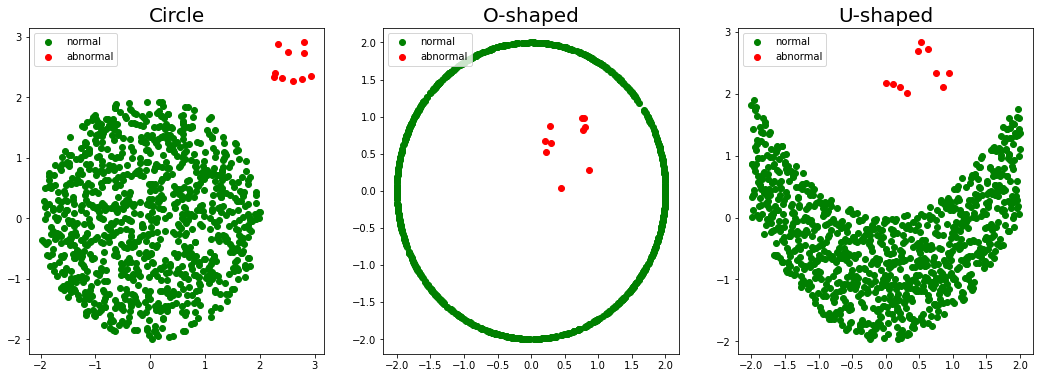

In [10]:
seed = 0
set_seed(seed)

n_normals = 990
n_abnormals = 10
n_train = 900
n_feats = 2


# circle data

R=2
minimum,xc,yc = 0,0,0
x1_c,x2_c = get_data_in_circle(R, minimum, xc, yc, n_normals)
x_circle = np.array([x1_c,x2_c]).T

abnormal_circle = np.random.rand(n_abnormals,n_feats)+(2,2)

# O-shaped
R=2
minimum,xc,yc = 1,0,0
x1_o,x2_o = get_data_in_circle(R, minimum, xc, yc, n_normals)
x_oshaped = np.array([x1_o,x2_o]).T

abnormal_oshaped = np.random.rand(n_abnormals,n_feats)


# U-shaped
x1_u = np.linspace(-2,2,n_normals)
x2_u = 0.5*x1_u**2-2+2*np.random.rand(n_normals)
x_ushaped = np.array([x1_u,x2_u]).T
abnormal_ushaped = np.random.rand(n_abnormals,n_feats)+(0,2)

normal_data = [x_circle,x_oshaped,x_ushaped]
abnormal_data = [abnormal_circle, abnormal_oshaped, abnormal_ushaped]


# make train, test datasets
data_dict={}

test_idxs = np.arange(n_normals-n_train+n_abnormals)
np.random.shuffle(test_idxs)
y_train = np.array([0]*n_train)
y_test = np.array([0]*90+[1]*n_abnormals)[test_idxs]


for name, normal, abnormal in zip(['Circle','O-shaped','U-shaped'], normal_data, abnormal_data):
    train, test = make_train_test_data(normal,abnormal,n_train)
    data_dict[name]={
        'train':train,
        'test':test[test_idxs,:]
    }

# plot the distributions of datasets
fig,axs = plt.subplots(ncols=3,figsize=(18,6))
for ax, normals, abnormals, title in zip(axs,normal_data, abnormal_data,['Circle','O-shaped','U-shaped']):
    ax.scatter(normals[:,0],normals[:,1], color='g',label='normal')
    ax.scatter(abnormals[:,0],abnormals[:,1],color='r',label='abnormal')
    ax.legend(loc=2)
    ax.set_title(title,size=20)


# Shape of Kernels

* There are several types of Kernel Density functions. In general, the most popular or well-used function is Guassian function. 

* Mathematical expressions of each Kernel Density function are as follows  

  1) cosine: $K(a,h) = cos(\frac{\pi a}{2h}) \,\, \text{if} \,\, |a|<h$  
  2) epanechnikov: $K(a,h) = 1-\frac{a^2}{h^2}$  
  3) exponential: $K(a,h)=exp(-\frac{|a|}{h})$  
  4) gaussian: $K(a,h)=exp(-\frac{a^2}{2h^2})$  
  5) linear: $K(a,h)=1-\frac{|a|}{h} \,\, \text{if}\,\,|a|<h$  
  6) tophat: $K(a,h)=1 \,\, \text{if} \,\, |a|<h$  

* The one and only hyper paramer of Kernel Density functions is $h$ called smoothing parameter or band width. It controls the shape of Kernel Density function

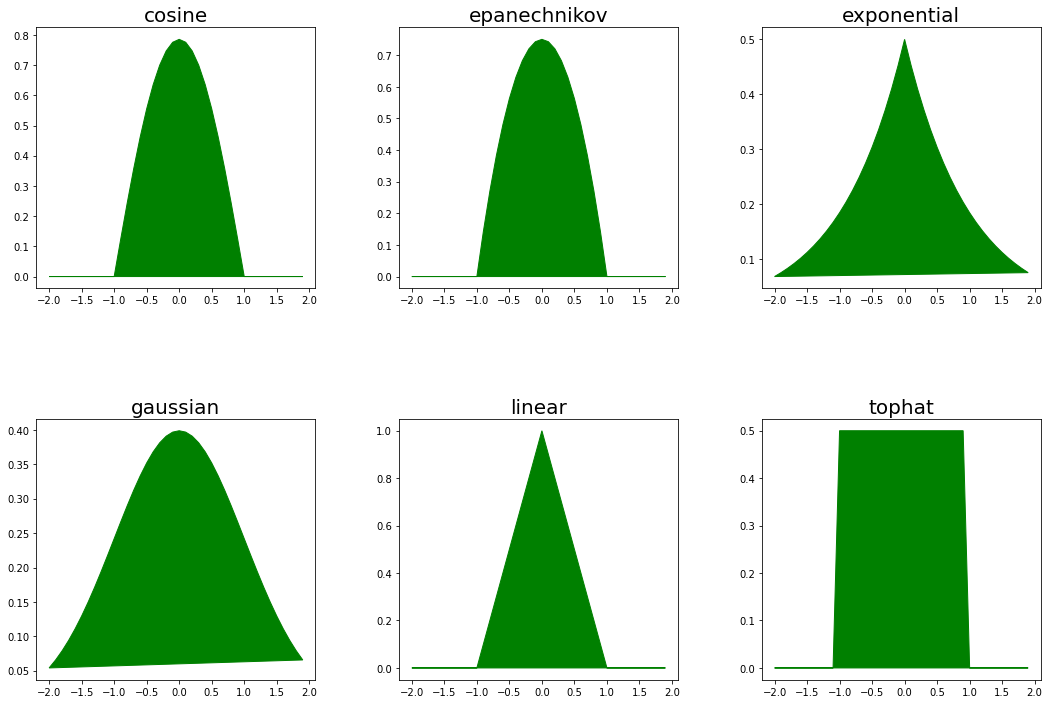

In [3]:
from sklearn.neighbors import KernelDensity

kernels = ['cosine', 'epanechnikov', 'exponential', 'gaussian', 'linear', 'tophat']
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
plt_ind = np.arange(6) + 231

for k, ind in zip(kernels, plt_ind):
    kde_model = KernelDensity(kernel=k)
    kde_model.fit([[0]])
    score = kde_model.score_samples(np.arange(-2, 2, 0.1)[:, None])
    plt.subplot(ind)
    plt.fill(np.arange(-2, 2, 0.1)[:, None], np.exp(score), c='green')
    plt.title(k,fontsize=20)

fig.subplots_adjust(hspace=0.5, wspace=.3)
plt.show()

* By changing the value of $h$, we can check the effect of it related to its Kernel Density Estimation

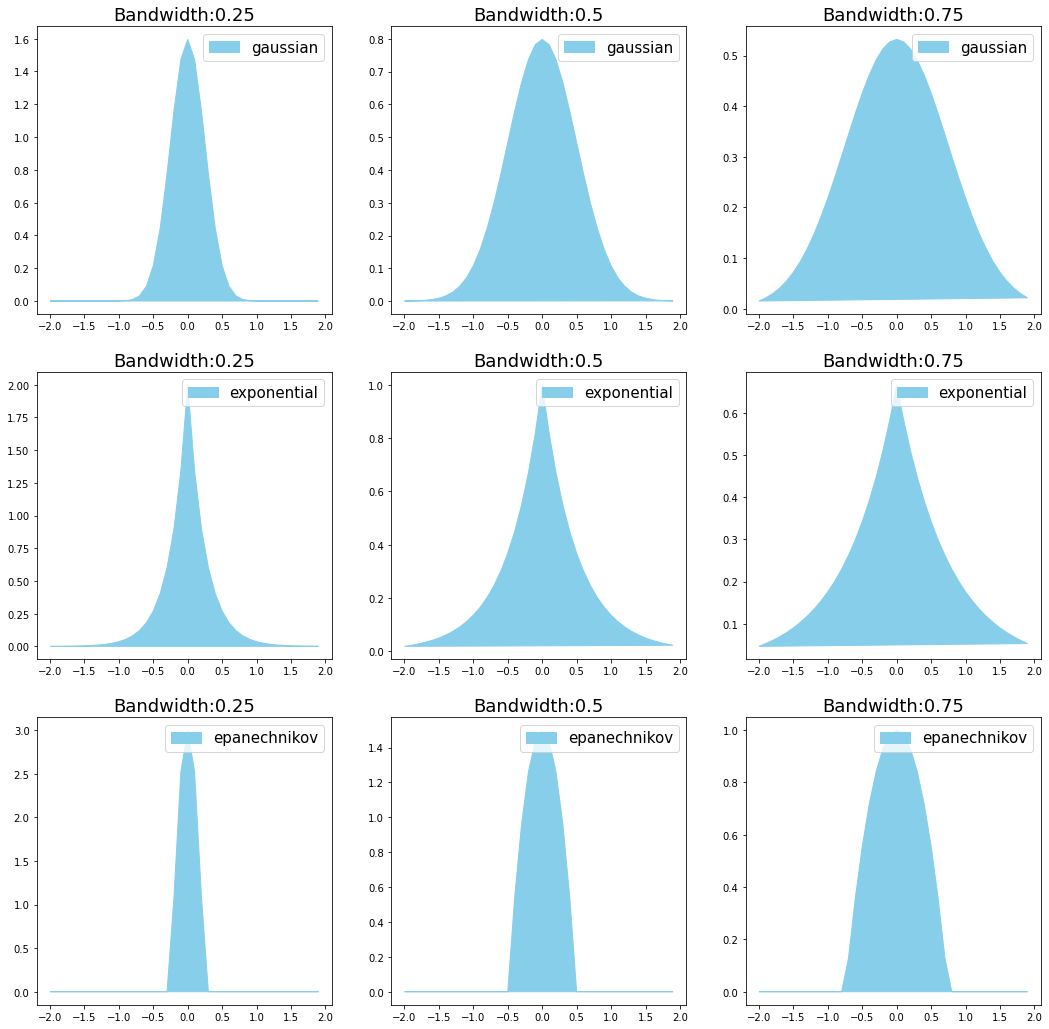

In [75]:
kernels = ['gaussian','exponential','epanechnikov']

nrows=ncols=3

h_lists = np.array([0.25, 0.5, 0.75])
fig = plt.figure(figsize=(18, 18))
i=1
for k in kernels:
    for h in h_lists:
        ax = fig.add_subplot(nrows,ncols,i)
        kde_model = KernelDensity(bandwidth=h,kernel=k,)
        kde_model.fit([[0]])
        score = kde_model.score_samples(np.arange(-2, 2, 0.1)[:, None])
        ax.fill(np.arange(-2, 2, 0.1)[:, None], np.exp(score), c='skyblue',label=k)
        ax.legend(fontsize=15)
        ax.set_title(f'Bandwidth:{h}',fontsize=18)
        i +=1



# Experiments

* Now we are going to get the results of how well each Kernel Density function fits to each dataset.

* Since $h$ can affect the results, Kernel Density functions are fitted with grid search of $h$

* Among many Kernel Density functions, we are going to check three functions: gaussian, exponential, epanechnikov

* We are going to draw ROC curves and AUC score is used to evaluate the models since the thresholds are different by datasets.

In [90]:
from sklearn.model_selection import GridSearchCV

def anomaly_scores(model, X):
    scores = model.score_samples(X)
    inf_idxs = scores != float('-inf')
    norm = np.linalg.norm(-scores[inf_idxs])
    scores = [score if not float('-inf') else -50 for score in scores]
    return -scores/norm



class GridKernelDensity(object):
    def __init__(self,kernel: str, parameter_args: dict) -> None:
        self.kernel = kernel
        self.parameter_args = parameter_args
    
    def anomaly_scores(self,model, X):
        scores = model.score_samples(X)
        self.inf_idxs = scores != float('-inf')
        
        norm = np.linalg.norm(-scores[self.inf_idxs])
        scores = scores[self.inf_idxs]
        
        return -np.array(scores)/norm

    def anomaly_mean_scores(self,model, X):
        scores = self.anomaly_scores(model,X)
        return np.mean(-scores)

    def fit(self,X: np.array):
        model = KernelDensity(kernel = self.kernel)
        self.grid = GridSearchCV(model,
                            self.parameter_args,
                            scoring=self.anomaly_mean_scores
                            )
        self.grid.fit(data_dict[name]['train'])
    
    def best_estimator(self,):
        return self.grid.best_estimator_
    
    def get_scores(self,X: np.array):
        best_estimator = self.best_estimator()
        test_scores = self.anomaly_scores(best_estimator,X)
        # test_scores = best_estimator.score_samples(X)
        return test_scores, self.inf_idxs

    def predict(self,X: np.array,threshold: float):
        test_scores,_ = self.get_scores(X)
        prediction = np.array([1 if score>=threshold else 0 for score in test_scores])
        return prediction


In [103]:
kernels = ['gaussian','exponential','cosine']
h_lists = np.arange(0.01,1,0.01)
data_names = ['Circle','O-shaped','U-shaped']

# Found the threshold emperically
threshold =0.2

results_dict={}
for data in data_names:
    result_dict= {}
    for kernel in kernels:
        grid_args=dict(
                kernel = kernel,
                parameter_args={
                    'bandwidth':h_lists,
                }
                )
        
        grid_kernel = GridKernelDensity(**grid_args)
        grid_kernel.fit(data_dict[data]['train'])
        prediction = grid_kernel.predict(data_dict[data]['test'],threshold)
        scores,inf_idxs = grid_kernel.get_scores(data_dict[data]['test'])
        result_dict[kernel] = {'prediction':prediction, 'scores':scores,'inf_idxs':inf_idxs,'best_h':round(grid_kernel.grid.best_params_['bandwidth'],2)}
    
    results_dict[data]=result_dict

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-p

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


,gaussian,exponential,cosine
Circle,0.990000,0.995556,NaN
O-shaped,0.655556,0.654444,0.722925
U-shaped,1.000000,1.000000,NaN


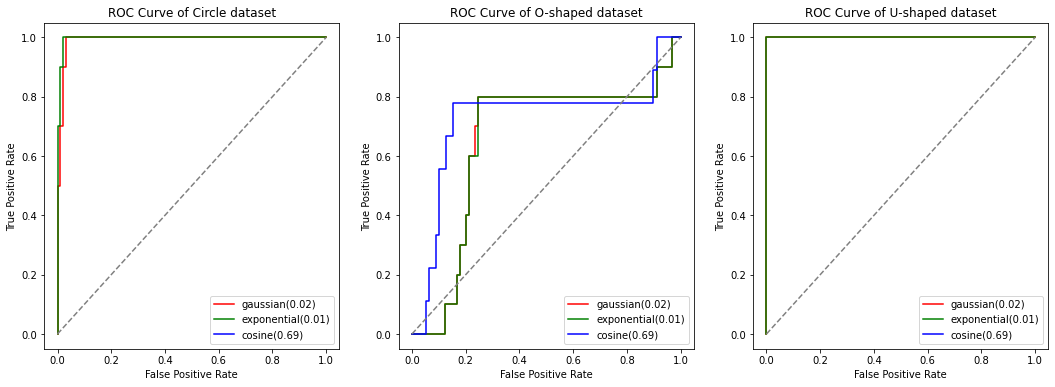

In [106]:
import os
from sklearn.metrics import roc_curve,auc

def get_roc_curve_figures(results_dict: dict, y_test: list = y_test)->pd.DataFrame:
    fig = plt.figure(figsize=(18,6))
    n_datasets = len(results_dict.values())
    
    AUC_dict = {}
    for i, (name, result_dict) in enumerate(results_dict.items()):
        # auc by kernels
        auc_dict = {}
        
        # kernel names
        kernels = list(result_dict.keys())

        # get scores and true labels
        scores = [result_dict[kernel]['scores'] for kernel in kernels]
        true_labels = [y_test[result_dict[kernel]['inf_idxs']==True] for kernel in kernels]
        fpr_tpr_list = [roc_curve(y_test,score) for y_test,score in zip(true_labels,scores)]
        
        # add subplot by dataset
        ax = fig.add_subplot(1,n_datasets,i+1)
        
        # draw roc curve and get auc score
        for j, (color, kernel) in enumerate(zip(['red','green','blue'],kernels)):
            ax.plot(fpr_tpr_list[j][0],fpr_tpr_list[j][1],color,label=f"{kernel}({result_dict[kernel]['best_h']})")
            auc_dict[kernel]=auc(fpr_tpr_list[j][0],fpr_tpr_list[j][1])
        
        ax.plot([0, 1], [0, 1], '--',color='gray')
        ax.set_title(f'ROC Curve of {name} dataset') # name of dataset
        ax.set_ylabel('True Positive Rate')
        ax.set_xlabel('False Positive Rate')
        ax.legend(loc=4)

        AUC_dict[name] = auc_dict

    img_folder = './roc_results' 
    os.makedirs(img_folder, exist_ok=True)
    image_path = os.path.join(img_folder,'ROC-Curves.png')
    plt.savefig(image_path)

    return pd.DataFrame(AUC_dict).transpose()
        

auc_df = get_roc_curve_figures(results_dict,y_test);auc_df

# Results

* As expected easily, Guassian and Exponential kernels work well with hyper-sphere shaped data samples and U-shaped ones as well.  

* But both of kernel density functions perform not that well on O-shaped data samples. In this case, Cosine kernel is the best.

* However Cosine kernel can not get the anomaly scores of Circle and U-shaped data samples since I guess it is non-continual unlike other kernel functions. 

* Also, the density is almost same in O-shaped data samples, which makes Cosinie kernel can perform as well.

* Lastly, as mentioned above, it is useful to check with Gaussian and Exponential kerenels when it hard to figure out how the data samples are ditributed since they are continual.